<a href="https://colab.research.google.com/github/joannawqy/R-DS/blob/main/shipping_emission_features63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [85]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
plt.rcParams['font.size'] = 16
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import HistGradientBoostingClassifier

# Load Data

In [2]:
fc_df = pd.read_csv('df_ml.csv')

In [ ]:
fc_df.describe()
# total.fc is the reported fc column
# FC_sum is the calculated fc colum
# need to do unit cinversion between these 2 column: 1000000 (total.fc * 1000000 is the same unit as FC_sum or u coulf FC _sum/1000000 vice versa)
# log(residual) = log(difference between FC_sum and total.fc) is the target variable
# calculated engineering varibales [W_component_first, ME_W_ref_first, t_m_times_v_n_sum, t_over_t_ref_with_m_sum, t_over_t_ref_without_m_sum, v_over_v_ref_without_n_sum]
# [Age(no log), Dwt, LBP..m., Beam.Mld..m., Draught..m, MRV.Load, TPC,  Service.Speed..knots., size category (encoding)]

,CVN,IMO.Number,mmsi,Built.Year,LDT,Demo.Price.LDT,Dwt,Beam.Mld..m.,Draught..m.,Price..NB.,...,ME_W_ref_first,t_m_times_v_n_sum,t_over_t_ref_with_m_sum,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,FC_sum,age,residual,distance_difference
count,1.354000e+03,1.354000e+03,1.354000e+03,1354.000000,261.000000,5.000000,1354.000000,1354.000000,1354.000000,294.000000,...,1354.000000,1.354000e+03,1354.000000,1354.000000,1354.000000,1354.000000,1.354000e+03,1354.000000,1354.000000,1354.000000
mean,1.650144e+07,9.494381e+06,4.440720e+08,2009.997784,11691.593870,495.400000,67271.742984,32.363996,12.756898,35.434728,...,9555.833087,6.847082e+06,1347.301248,1257.088662,511.420379,747.858744,9.847440e+08,9.528804,0.371887,163.156387
std,6.518597e+06,2.217332e+05,1.399822e+08,5.691437,5609.509132,139.901036,43437.076413,5.489730,2.526049,19.584127,...,3446.391301,4.903889e+06,972.825324,919.059586,367.601756,509.038724,7.609085e+08,5.699508,0.361690,136.081093
min,1.100120e+07,7.342469e+06,2.055690e+08,1976.000000,3179.000000,310.000000,10100.000000,15.900000,6.790000,2.100000,...,1913.000000,5.832958e+04,45.531292,39.408295,8.192013,15.123813,6.540175e+06,0.000000,-1.166844,0.133402
25%,1.602440e+07,9.370333e+06,3.130085e+08,2007.000000,8187.000000,379.000000,37309.000000,30.000000,10.500000,24.500000,...,7064.500000,3.488031e+06,681.435494,628.347588,254.843037,391.343698,4.642471e+08,6.000000,0.139521,52.761401
50%,1.615024e+07,9.512343e+06,4.773497e+08,2011.000000,9901.000000,595.000000,57027.000000,32.260000,12.800000,31.025000,...,8951.000000,5.557716e+06,1057.661949,975.566964,412.757636,610.568007,7.697701e+08,8.000000,0.318058,119.928016
75%,1.622338e+07,9.629491e+06,5.380082e+08,2013.000000,12960.000000,595.000000,79885.250000,32.260000,14.250000,40.000000,...,10915.000000,9.026104e+06,1719.001956,1613.177080,654.133948,978.534996,1.290988e+09,12.000000,0.554796,251.779097
max,8.045133e+07,9.875733e+06,6.670020e+08,2020.000000,28600.000000,598.000000,300660.000000,55.000000,21.420000,169.360000,...,21840.000000,6.426647e+07,6060.975394,5858.291697,2362.312656,3387.322710,6.466497e+09,43.000000,3.120664,499.916359


In [ ]:
fc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Columns: 276 entries, CVN to distance_difference
dtypes: float64(149), int64(7), object(120)
memory usage: 2.9+ MB


In [ ]:
fc_df.head(5)

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,ME_W_ref_first,t_m_times_v_n_sum,t_over_t_ref_with_m_sum,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,FC_sum,age,residual,distance_difference
0,16057894,9398137,Onozuru Maru,354043000.0,NaN,Panama,Nippon Yusen Kaisha,Toyo Sangyo,Seno Kisen,2009-07-01,...,16370.0,9978525.0,1586.912988,1469.730955,558.509179,942.002078,1.779969e+09,10,0.497589,222.738499
1,16030576,9374040,Berge Kuju,232012567.0,Mineral Shikoku,Isle of Man,NaN,Berge Bulk,Berge Bulk,2006-10-01,...,18660.0,14237486.0,3323.778876,3183.717628,729.614198,1604.106395,3.071670e+09,14,0.370380,58.090463
2,15860965,9312250,Azul Libero,564690000.0,NaN,Singapore,Kumiai Navigation,Kumiai Navigation,Kumiai Senpaku,2004-10-01,...,16861.0,14140232.0,2077.618585,2042.515529,680.404287,1237.660468,2.608599e+09,16,0.304478,37.862244
3,16112410,9500637,Navios Lumen,354700000.0,NaN,Panama,SwissMarine Services,Navios Holdings,Navios Holdings,2009-12-01,...,18651.0,2019604.2,847.569559,781.778846,115.956963,418.864410,4.476525e+08,10,1.060820,193.888735
4,16072789,9434553,Mariloula,538004701.0,NaN,Marshall Is.,Chandris (Hellas),Chandris (Hellas),Chandris Group,2008-11-01,...,13560.0,5745806.5,431.509397,408.483887,307.830689,385.189664,8.821422e+08,11,0.312424,1.265483


# Feature Engineering


## Create Target Variable - residual

In [3]:
fc_df['total.fc'] = fc_df['total.fc']*100000

In [4]:
fc_df[['total.fc','FC_sum']]

,total.fc,FC_sum
0,292825000.0,1.779969e+09
1,444910000.0,3.071670e+09
2,353740000.0,2.608599e+09
3,129504000.0,4.476525e+08
4,120602000.0,8.821422e+08
...,...,...
1349,56463000.0,4.214761e+08
1350,227100000.0,1.472380e+09
1351,134007000.0,1.082872e+09
1352,176810000.0,1.327235e+09


For all calculated values, they have been overestimated, except for one

## Compute target - residual


In [5]:
fc_df.drop('residual', axis=1)

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,W_component_first,ME_W_ref_first,t_m_times_v_n_sum,t_over_t_ref_with_m_sum,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,FC_sum,age,distance_difference
0,16057894,9398137,Onozuru Maru,354043000.0,NaN,Panama,Nippon Yusen Kaisha,Toyo Sangyo,Seno Kisen,2009-07-01,...,0.000058,16370.0,9978525.0,1586.912988,1469.730955,558.509179,942.002078,1.779969e+09,10,222.738499
1,16030576,9374040,Berge Kuju,232012567.0,Mineral Shikoku,Isle of Man,NaN,Berge Bulk,Berge Bulk,2006-10-01,...,0.000061,18660.0,14237486.0,3323.778876,3183.717628,729.614198,1604.106395,3.071670e+09,14,58.090463
2,15860965,9312250,Azul Libero,564690000.0,NaN,Singapore,Kumiai Navigation,Kumiai Navigation,Kumiai Senpaku,2004-10-01,...,0.000059,16861.0,14140232.0,2077.618585,2042.515529,680.404287,1237.660468,2.608599e+09,16,37.862244
3,16112410,9500637,Navios Lumen,354700000.0,NaN,Panama,SwissMarine Services,Navios Holdings,Navios Holdings,2009-12-01,...,0.000056,18651.0,2019604.2,847.569559,781.778846,115.956963,418.864410,4.476525e+08,10,193.888735
4,16072789,9434553,Mariloula,538004701.0,NaN,Marshall Is.,Chandris (Hellas),Chandris (Hellas),Chandris Group,2008-11-01,...,0.000061,13560.0,5745806.5,431.509397,408.483887,307.830689,385.189664,8.821422e+08,11,1.265483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,16258543,9701243,Tia Marta,538006538.0,NaN,Marshall Is.,Sealink Navigation,Sealink Navigation,Sealink Navigation,2015-09-01,...,0.000101,7038.0,3205527.5,740.020229,675.946729,283.183642,346.047642,4.214761e+08,4,152.142017
1350,16069989,9432531,Pluto,636016416.0,NaN,Liberia,"Blumenthal, Johann","Blumenthal, Johann","Blumenthal, Johann",2014-04-01,...,0.000096,6840.0,12062349.0,3765.919506,3550.499222,1026.681755,1524.565413,1.472380e+09,5,459.467851
1351,16234842,9666431,African Kalmia,636015892.0,NaN,Liberia,Seaboard O'seas Ltd.,Seaboard O'seas Ltd.,Seaboard Overseas,2016-01-01,...,0.000110,4950.0,10633594.0,2294.275233,2167.222971,1020.364409,1342.358878,1.082872e+09,4,444.053327
1352,16331934,9802695,Egbert Wagenborg,244060083.0,NaN,Netherlands,Wagenborg Shipping,Wagenborg Shipping,Wagenborg Shipping,2017-04-01,...,0.000200,2999.0,10819893.0,4203.545504,3950.284339,1910.149114,2556.583517,1.327235e+09,2,414.414842


In [123]:
fc_df['FC_sum']=np.log1p(fc_df['FC_sum'])
fc_df['total.fc']=np.log1p(fc_df['total.fc'])

In [124]:
fc_df['residual']=fc_df['total.fc']-fc_df['FC_sum']

In [125]:
fc_df[fc_df['residual']<0]

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,ME_W_ref_first,t_m_times_v_n_sum,t_over_t_ref_with_m_sum,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,FC_sum,age,residual,distance_difference
0,16057894,9398137,Onozuru Maru,354043000.0,NaN,Panama,Nippon Yusen Kaisha,Toyo Sangyo,Seno Kisen,2009-07-01,...,16370.0,9978525.0,1586.912988,1469.730955,558.509179,942.002078,3.104580,10,-0.084395,222.738499
1,16030576,9374040,Berge Kuju,232012567.0,Mineral Shikoku,Isle of Man,NaN,Berge Bulk,Berge Bulk,2006-10-01,...,18660.0,14237486.0,3323.778876,3183.717628,729.614198,1604.106395,3.128754,14,-0.088364,58.090463
2,15860965,9312250,Azul Libero,564690000.0,NaN,Singapore,Kumiai Navigation,Kumiai Navigation,Kumiai Senpaku,2004-10-01,...,16861.0,14140232.0,2077.618585,2042.515529,680.404287,1237.660468,3.121575,16,-0.092211,37.862244
3,16112410,9500637,Navios Lumen,354700000.0,NaN,Panama,SwissMarine Services,Navios Holdings,Navios Holdings,2009-12-01,...,18651.0,2019604.2,847.569559,781.778846,115.956963,418.864410,3.040683,10,-0.061120,193.888735
4,16072789,9434553,Mariloula,538004701.0,NaN,Marshall Is.,Chandris (Hellas),Chandris (Hellas),Chandris Group,2008-11-01,...,13560.0,5745806.5,431.509397,408.483887,307.830689,385.189664,3.072594,11,-0.096656,1.265483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,16258543,9701243,Tia Marta,538006538.0,NaN,Marshall Is.,Sealink Navigation,Sealink Navigation,Sealink Navigation,2015-09-01,...,7038.0,3205527.5,740.020229,675.946729,283.183642,346.047642,3.037799,4,-0.101334,152.142017
1350,16069989,9432531,Pluto,636016416.0,NaN,Liberia,"Blumenthal, Johann","Blumenthal, Johann","Blumenthal, Johann",2014-04-01,...,6840.0,12062349.0,3765.919506,3550.499222,1026.681755,1524.565413,3.096037,5,-0.088331,459.467851
1351,16234842,9666431,African Kalmia,636015892.0,NaN,Liberia,Seaboard O'seas Ltd.,Seaboard O'seas Ltd.,Seaboard Overseas,2016-01-01,...,4950.0,10633594.0,2294.275233,2167.222971,1020.364409,1342.358878,3.082042,4,-0.100743,444.053327
1352,16331934,9802695,Egbert Wagenborg,244060083.0,NaN,Netherlands,Wagenborg Shipping,Wagenborg Shipping,Wagenborg Shipping,2017-04-01,...,2999.0,10819893.0,4203.545504,3950.284339,1910.149114,2556.583517,3.091332,2,-0.096070,414.414842


In [126]:
fc_df[['FC_sum','total.fc','residual']].describe()

,FC_sum,total.fc,residual
count,1354.000000,1354.000000,1354.000000
mean,3.063215,2.968859,-0.094355
std,0.040077,0.037744,0.017357
min,2.815018,2.742989,-0.168564
25%,3.042422,2.948169,-0.105353
50%,3.066265,2.971254,-0.096380
75%,3.090073,2.993510,-0.085369
max,3.160819,3.068012,0.045684


## Feature Selection

### Primary Feature Selected

In [127]:
features_selected = ['Dwt','Size.Category','Beam.Mld..m.','Draught..m.','HP.Total.Propulsion','Service.Speed..knots.','Holds.Total.No','Grain.Capacity..cu.m.','Type','Est.Crew.No','LOA..m.','Laden.Speed..knots.','Status','GT','Beta.Atlantic.Pacific.Based..Last.12.Months.','Operational.Speed..knots.','TPC','NT','Ballast.Cap..cu.m.','Bale.Capacity..cu.m.','Sister.Vessel.Code','P.and.I.Club.','CGT','LBP..m.','Gear..Ind.','Speed..knots.','Speed.category','BWMS.Status','Hatches.Total.No','West.Coast.Africa.Deployment..Time.in.Last.12.Months....','Depth.Moulded..m.','Group','ship.type','efficiency.metric','technical.efficiency','total.co2','co2.between.ms.ports','co2.from.ms.ports','co2.to.ms.ports','co2.ms.ports.at.berth','time.at.sea','fc.per.distance','fc.per.work.mass','co2.per.distance','co2.per.work.mass','EU.distance','speed','emission.factor','work.mass','load','distance_sum','work_sum','work_IS_sum','trip_nunique','W_component_first','ME_W_ref_first','t_m_times_v_n_sum','t_over_t_ref_with_m_sum','t_over_t_ref_without_m_sum','v_over_v_ref_with_n_sum','v_over_v_ref_without_n_sum','age','distance_difference']

In [128]:
fc_df[features_selected].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 63 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Dwt                                                       1354 non-null   float64
 1   Size.Category                                             1354 non-null   object 
 2   Beam.Mld..m.                                              1354 non-null   float64
 3   Draught..m.                                               1354 non-null   float64
 4   HP.Total.Propulsion                                       1354 non-null   float64
 5   Service.Speed..knots.                                     1354 non-null   float64
 6   Holds.Total.No                                            1354 non-null   float64
 7   Grain.Capacity..cu.m.                                     1330 non-null   float64
 8   Type              

# Train Test Split

In [129]:
df_train, df_test = train_test_split(fc_df,test_size=0.2, random_state=123)

In [130]:
len(df_test)/len(df_train)

0.2502308402585411

In [131]:
len(df_test)

271

## Seperate X and y







In [132]:
X_train = df_train[features_selected]
y_train = df_train['residual']

X_test  = df_test[features_selected]
y_test = df_test['residual']

## Seperate Numerical N Categorical Variables

numerical variables


> ['Dwt', 'Beam.Mld..m.', 'Draught..m.', 'HP.Total.Propulsion',
       'Service.Speed..knots.', 'Holds.Total.No', 'Grain.Capacity..cu.m.',
       'Est.Crew.No', 'LOA..m.', 'Laden.Speed..knots.', 'GT',
       'Operational.Speed..knots.', 'TPC', 'NT', 'Ballast.Cap..cu.m.',
       'Bale.Capacity..cu.m.', 'Sister.Vessel.Code', 'CGT', 'LBP..m.',
       'Speed..knots.', 'Hatches.Total.No',
       'West.Coast.Africa.Deployment..Time.in.Last.12.Months....',
       'Depth.Moulded..m.', 'technical.efficiency', 'total.co2',
       'co2.between.ms.ports', 'co2.from.ms.ports', 'co2.to.ms.ports',
       'co2.ms.ports.at.berth', 'time.at.sea', 'fc.per.distance',
       'fc.per.work.mass', 'co2.per.distance', 'co2.per.work.mass',
       'EU.distance', 'speed', 'emission.factor', 'work.mass', 'load',
       'distance_sum', 'work_sum', 'work_IS_sum', 'trip_nunique',
       'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
       't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
       'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum', 'age',
       'distance_difference']



In [51]:
categorical_features=['Size.Category', 'Type', 'Status',
       'Beta.Atlantic.Pacific.Based..Last.12.Months.',
        'P.and.I.Club.', 'Gear..Ind.',
       'Speed.category', 'BWMS.Status', 'Group', 'ship.type',
       'efficiency.metric']
numeric_features=['Dwt', 'Beam.Mld..m.', 'Draught..m.', 'HP.Total.Propulsion',
       'Service.Speed..knots.', 'Holds.Total.No', 'Grain.Capacity..cu.m.',
       'Est.Crew.No', 'LOA..m.', 'Laden.Speed..knots.', 'GT',
       'Operational.Speed..knots.', 'TPC', 'NT', 'Ballast.Cap..cu.m.',
       'Bale.Capacity..cu.m.', 'Sister.Vessel.Code', 'CGT', 'LBP..m.',
       'Speed..knots.', 'Hatches.Total.No',
       'West.Coast.Africa.Deployment..Time.in.Last.12.Months....',
       'Depth.Moulded..m.', 'technical.efficiency', 'total.co2',
       'co2.between.ms.ports', 'co2.from.ms.ports', 'co2.to.ms.ports',
       'co2.ms.ports.at.berth', 'time.at.sea', 'fc.per.distance',
       'fc.per.work.mass', 'co2.per.distance', 'co2.per.work.mass',
       'EU.distance', 'speed', 'emission.factor', 'work.mass', 'load',
       'distance_sum', 'work_sum', 'work_IS_sum', 'trip_nunique',
       'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
       't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
       'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum',
       'distance_difference']
target_column='residual'

# Preprocessing Pipeline

In [52]:
def log_transform(x):
    return np.log1p(x)

In [53]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])

In [58]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [59]:
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
])

# Algorithm Selection

## Baseline Regression Model

In [133]:
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [134]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x79923eda6560>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dwt', 'Beam.Mld..m.',
                                                   'Draught..m.',
                                                   'HP.Total.Propulsion',
                                                   'Service.Speed..knots.',
                                                   'Holds.Total.No',
                                                   '...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Size.Category', 'Type',
                                                   'Status',
                                                   'Beta.Atlantic.Pacific.Based..Last.12.Months.',
                                                   'P.and.I.Club.',
                                                   'Gear..Ind.',
                                                   'Speed.category',
                                                   'BWMS.Status', 'Group',
                                                   'ship.type',
                                                   'efficiency.metric'])])),
                ('regressor', LinearRegression())])

In [135]:
pd.DataFrame(cross_validate(lr, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.040619,0.011353,-4.534558e+20,0.997244
1,0.046514,0.010681,-5.071199e+20,0.997250
2,0.055827,0.020573,9.956512e-01,0.997044
3,0.106920,0.025137,9.952771e-01,0.997074
4,0.090625,0.037033,9.938866e-01,0.997189
5,0.118618,0.025325,-1.499733e+21,0.997008
6,0.139934,0.023330,9.961201e-01,0.997116
7,0.114161,0.016159,-2.782404e+19,0.997065
8,0.119888,0.016313,-1.044757e+20,0.997104
9,0.080904,0.011453,9.944223e-01,0.997306


In [136]:
print(pd.DataFrame(cross_validate(lr, X_train, y_train, cv=10, return_train_score=True))['test_score'].abs().mean())

2.5926081307081425e+20


### Fit on Test

In [137]:
y_pred = lr.predict(X_test)

In [138]:
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'], index=X_test.index)
y_test_with_pred = pd.concat([y_test, y_pred_df], axis=1)
print(y_test_with_pred)

      residual  prediction
31   -0.085772   -0.085955
1115 -0.109943   -0.111162
903  -0.105550   -0.105211
274  -0.084991   -0.085875
18   -0.085137   -0.085077
...        ...         ...
246  -0.112315   -0.112579
81   -0.088902   -0.089046
120  -0.083508   -0.083853
582  -0.082529   -0.082510
1302 -0.125904   -0.122969

[271 rows x 2 columns]


#### MSE

In [139]:
mean_squared_error(y_test, y_pred)

2.150281903180671e-06

#### R^2

In [140]:
lr.score(X_test, y_test)

0.9932348232549458

## Ridge Regression

In [141]:
rr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))
])

In [142]:
rr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x79923eda6560>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dwt', 'Beam.Mld..m.',
                                                   'Draught..m.',
                                                   'HP.Total.Propulsion',
                                                   'Service.Speed..knots.',
                                                   'Holds.Total.No',
                                                   '...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Size.Category', 'Type',
                                                   'Status',
                                                   'Beta.Atlantic.Pacific.Based..Last.12.Months.',
                                                   'P.and.I.Club.',
                                                   'Gear..Ind.',
                                                   'Speed.category',
                                                   'BWMS.Status', 'Group',
                                                   'ship.type',
                                                   'efficiency.metric'])])),
                ('regressor', Ridge(alpha=10))])

### Cross-Validation

In [143]:
pd.DataFrame(cross_validate(rr, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.038538,0.023276,0.975058,0.989254
1,0.077554,0.020641,0.988399,0.989132
2,0.070141,0.010751,0.991855,0.988444
3,0.087021,0.020043,0.986597,0.989115
4,0.039949,0.010829,0.986421,0.989139
5,0.064659,0.013851,0.990169,0.988919
6,0.092481,0.031088,0.982189,0.989103
7,0.103141,0.027661,0.991409,0.988962
8,0.115762,0.039642,0.983657,0.989138
9,0.094371,0.038502,0.977485,0.989646


In [144]:
print(pd.DataFrame(cross_validate(rr, X_train, y_train, cv=10, return_train_score=True))['test_score'].abs().mean())

0.9853238501517761


In [145]:
rr.score(X_test, y_test)

0.9885939920799431

## Lasso

In [153]:
ls = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.0001))
])

In [154]:
ls.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x79923eda6560>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dwt', 'Beam.Mld..m.',
                                                   'Draught..m.',
                                                   'HP.Total.Propulsion',
                                                   'Service.Speed..knots.',
                                                   'Holds.Total.No',
                                                   '...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Size.Category', 'Type',
                                                   'Status',
                                                   'Beta.Atlantic.Pacific.Based..Last.12.Months.',
                                                   'P.and.I.Club.',
                                                   'Gear..Ind.',
                                                   'Speed.category',
                                                   'BWMS.Status', 'Group',
                                                   'ship.type',
                                                   'efficiency.metric'])])),
                ('regressor', Lasso(alpha=0.0001))])

### Cross-validation

In [155]:
pd.DataFrame(cross_validate(ls, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.111491,0.034264,0.976864,0.993176
1,0.149876,0.034621,0.991512,0.993135
2,0.150876,0.032337,0.993602,0.992642
3,0.149452,0.038099,0.993714,0.992947
4,0.166436,0.032040,0.991415,0.992976
5,0.157409,0.039083,0.993455,0.992813
6,0.062698,0.011480,0.993831,0.992952
7,0.062016,0.011535,0.995333,0.992768
8,0.112650,0.017699,0.990397,0.993091
9,0.100193,0.011177,0.990772,0.993120


In [156]:
print(pd.DataFrame(cross_validate(ls, X_train, y_train, cv=10, return_train_score=True))['test_score'].abs().mean())

0.9910895226053332


In [157]:
ls.score(X_test, y_test)

0.9946066592219897

## DecisionTree

In [158]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

In [159]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x79923eda6560>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dwt', 'Beam.Mld..m.',
                                                   'Draught..m.',
                                                   'HP.Total.Propulsion',
                                                   'Service.Speed..knots.',
                                                   'Holds.Total.No',
                                                   '...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Size.Category', 'Type',
                                                   'Status',
                                                   'Beta.Atlantic.Pacific.Based..Last.12.Months.',
                                                   'P.and.I.Club.',
                                                   'Gear..Ind.',
                                                   'Speed.category',
                                                   'BWMS.Status', 'Group',
                                                   'ship.type',
                                                   'efficiency.metric'])])),
                ('regressor', DecisionTreeRegressor())])

### Cross-validation

In [160]:
pd.DataFrame(cross_validate(model, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.086509,0.007987,-0.275864,1.0
1,0.070926,0.010090,0.043738,1.0
2,0.070848,0.009137,0.130932,1.0
3,0.070151,0.010804,-0.350039,1.0
4,0.073388,0.007618,-0.018083,1.0
5,0.071451,0.008087,0.027840,1.0
6,0.072664,0.007884,0.025806,1.0
7,0.069347,0.007803,0.238002,1.0
8,0.073994,0.013401,0.102253,1.0
9,0.071559,0.007821,0.288283,1.0


flully-grown tree -> overfitting

In [161]:
print(pd.DataFrame(cross_validate(model, X_train, y_train, cv=10, return_train_score=True))['test_score'].abs().mean())

0.1604363972781823


### Informal Hyperparamter Tuning

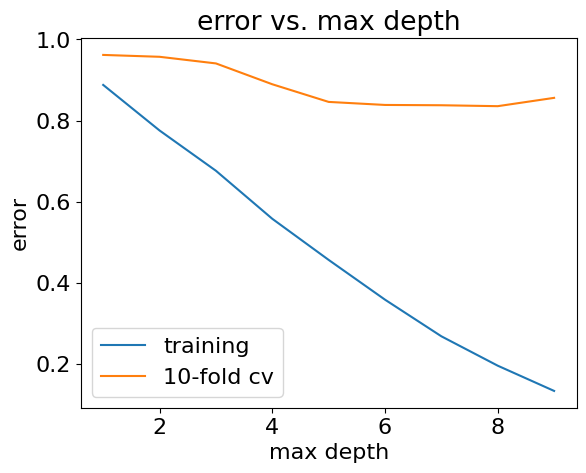

In [162]:
max_depths = np.arange(1, 10)
train_error = []
cv_error = []
for depth in max_depths:
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=depth, random_state=123))
    ])
    cv_scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    train_error.append(1 - cv_scores["train_score"].mean())
    cv_error.append(1 - cv_scores["test_score"].mean())

plt.plot(max_depths, train_error, label="training");
plt.plot(max_depths, cv_error, label="10-fold cv");
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");
plt.legend();

5 looks like a reasonable depth to use, but a very best model in general

### Attempt 2

In [165]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=5))
])

In [166]:
dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x79923eda6560>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dwt', 'Beam.Mld..m.',
                                                   'Draught..m.',
                                                   'HP.Total.Propulsion',
                                                   'Service.Speed..knots.',
                                                   'Holds.Total.No',
                                                   '...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Size.Category', 'Type',
                                                   'Status',
                                                   'Beta.Atlantic.Pacific.Based..Last.12.Months.',
                                                   'P.and.I.Club.',
                                                   'Gear..Ind.',
                                                   'Speed.category',
                                                   'BWMS.Status', 'Group',
                                                   'ship.type',
                                                   'efficiency.metric'])])),
                ('regressor', DecisionTreeRegressor(max_depth=5))])

In [167]:
pd.DataFrame(cross_validate(dt, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.062272,0.008480,0.037861,0.506221
1,0.048693,0.007795,0.234238,0.576939
2,0.045233,0.008444,0.411730,0.519416
3,0.042868,0.007436,0.122505,0.522770
4,0.046743,0.007812,0.009334,0.525209
5,0.047731,0.008630,0.214374,0.556895
6,0.047683,0.007509,0.046068,0.556950
7,0.044712,0.008704,0.305310,0.541066
8,0.052266,0.007993,0.304211,0.558558
9,0.044673,0.008260,0.198910,0.571613


In [168]:
print(pd.DataFrame(cross_validate(dt, X_train, y_train, cv=10, return_train_score=True))['test_score'].abs().mean())

0.17484312105552866


## Other Ensembles

In [82]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.3 MB/s eta 0:00:00


In [83]:
import xgboost as xgboost
import lightgbm as lightgbm
import catboost as catboost

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

### Random Forest

In [169]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=123))
])

### XGBoost

In [170]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror',random_state=123))
])

### LGBM

In [171]:
lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(objective='regression',random_state=123))
])

### CatBoost

In [172]:
cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(loss_function='RMSE',random_state=123))
])

# Cross Validation Table for All Regressor

In [173]:
regressors = {
    'linear regression' : lr,
    'ridge regression': rr,
    'lasso regression': ls,
    'decision tree' : dt,
    'random forest' : rf,
    'XGBoost' : xgb,
    'LightGBM' : lgb,
    'CatBoost' : cb
}

In [ ]:
mean_results_dict = dict()
std_results_dict = dict()
for name, regressor in regressors.items():
    print(name)
    result = pd.DataFrame(cross_validate(regressor, X_train, y_train, return_train_score=True))
    mean_results_dict[name] = result.mean()
    std_results_dict[name] = result.std()

In [175]:
results = pd.DataFrame(mean_results_dict).T
std_results  = pd.DataFrame(std_results_dict).T

In [176]:
results = results.assign(test_score_std=std_results["test_score"])

In [177]:
results.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score,test_score_std
lasso regression,0.119649,0.032459,9.912360e-01,0.993022,3.944097e-03
ridge regression,0.071095,0.020114,9.845985e-01,0.988291,4.273806e-03
CatBoost,14.845660,0.016337,8.309752e-01,0.998370,6.190854e-02
LightGBM,0.418278,0.015666,7.789397e-01,0.964746,5.730528e-02
XGBoost,0.502860,0.011963,6.928136e-01,0.998960,3.149714e-02
random forest,3.083453,0.019459,5.695944e-01,0.939158,3.079354e-02
decision tree,0.076042,0.012925,1.443320e-01,0.551229,1.270642e-01
linear regression,0.058002,0.022487,-9.321849e+18,0.997206,1.028656e+19


# Hyperparameter Tuning [skipped for now]

## Tunning Catboost

In [178]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X)


In [179]:
preprocessor_hpt = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log_transform', LogTransformer()),
            ('scaler', StandardScaler())
        ]), ['Dwt', 'Main.Engine.Power.kW', 'LBP..m.', 'Beam.Mld..m.', 'Draught..m.', 'MRV.Load', 'TPC', 'AIS.EU.Work']),
        ('categorical', OneHotEncoder(), ['Size.Category'])
    ])

In [180]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(loss_function='RMSE',random_state=123))
])

In [181]:
param_grid = {
    'regressor__iterations': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 1.0],
    'regressor__depth': [3, 5, 7]
}


random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

Streaming output truncated to the last 5000 lines.
200:	learn: 0.0027224	total: 2.42s	remaining: 1.19s
201:	learn: 0.0027059	total: 2.43s	remaining: 1.18s
202:	learn: 0.0026815	total: 2.44s	remaining: 1.16s
203:	learn: 0.0026678	total: 2.44s	remaining: 1.15s
204:	learn: 0.0026547	total: 2.45s	remaining: 1.14s
205:	learn: 0.0026397	total: 2.46s	remaining: 1.12s
206:	learn: 0.0026143	total: 2.46s	remaining: 1.11s
207:	learn: 0.0025953	total: 2.47s	remaining: 1.09s
208:	learn: 0.0025783	total: 2.48s	remaining: 1.08s
209:	learn: 0.0025658	total: 2.49s	remaining: 1.06s
210:	learn: 0.0025514	total: 2.49s	remaining: 1.05s
211:	learn: 0.0025365	total: 2.5s	remaining: 1.04s
212:	learn: 0.0025229	total: 2.51s	remaining: 1.02s
213:	learn: 0.0025065	total: 2.52s	remaining: 1.01s
214:	learn: 0.0025026	total: 2.53s	remaining: 1000ms
215:	learn: 0.0024883	total: 2.54s	remaining: 986ms
216:	learn: 0.0024712	total: 2.54s	remaining: 972ms
217:	learn: 0.0024591	total: 2.55s	remaining: 959ms
218:	learn: 0

In [182]:
print(best_params)

{'regressor__learning_rate': 0.1, 'regressor__iterations': 300, 'regressor__depth': 5}


In [183]:
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'regressor__learning_rate': 0.1, 'regressor__iterations': 300, 'regressor__depth': 5}
Best Score: 0.8288813639429815


In [184]:
best_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(iterations=300, learning_rate=0.1, depth=5,loss_function='RMSE',random_state=123))
])

In [185]:
best_cb.fit(X_train, y_train)
y_pred = best_cb.predict(X_test)

0:	learn: 0.0169031	total: 6.94ms	remaining: 2.08s
1:	learn: 0.0165543	total: 15ms	remaining: 2.24s
2:	learn: 0.0161635	total: 22.8ms	remaining: 2.25s
3:	learn: 0.0158339	total: 33.5ms	remaining: 2.48s
4:	learn: 0.0155824	total: 40.8ms	remaining: 2.4s
5:	learn: 0.0153128	total: 47.8ms	remaining: 2.34s
6:	learn: 0.0150961	total: 55.2ms	remaining: 2.31s
7:	learn: 0.0148922	total: 62.6ms	remaining: 2.29s
8:	learn: 0.0147178	total: 72ms	remaining: 2.33s
9:	learn: 0.0144909	total: 89ms	remaining: 2.58s
10:	learn: 0.0143602	total: 98.9ms	remaining: 2.6s
11:	learn: 0.0141344	total: 106ms	remaining: 2.55s
12:	learn: 0.0139205	total: 113ms	remaining: 2.5s
13:	learn: 0.0138154	total: 120ms	remaining: 2.46s
14:	learn: 0.0136343	total: 129ms	remaining: 2.44s
15:	learn: 0.0135392	total: 136ms	remaining: 2.41s
16:	learn: 0.0134262	total: 143ms	remaining: 2.38s
17:	learn: 0.0132782	total: 150ms	remaining: 2.35s
18:	learn: 0.0130642	total: 157ms	remaining: 2.32s
19:	learn: 0.0128862	total: 164ms	remai

In [186]:
best_cb.score(X_test, y_test)

0.8342713616839864

# Out-of-sample Testing -- Catboost [skipped for now]

In [ ]:
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'], index=X_test.index)
y_test_with_pred = pd.concat([y_test, y_pred_df], axis=1)
print(y_test_with_pred)

      residual  prediction
31    9.489525    9.479698
1115  9.428205    9.403345
903   8.726511    8.723344
274   8.626751    8.617753
18    8.831366    8.809505
...        ...         ...
246   8.837371    8.827922
81    8.867131    8.863948
120   8.668083    8.677446
582   8.428472    8.416408
1302  8.062787    8.028777

[271 rows x 2 columns]


In [ ]:
cb.score(X_test, y_test)

0.963244180828705

In [ ]:
print(cb.get_params()['regressor'].get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 123, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.0414620004594326, 'score_function': 'Cosine', 'task_type': 'CPU', 'lea

Iteration = 1000, Depth = 6, learning_rate = 0.0414620004594326

This is so high

# Prediction Score Table

In [189]:
regressors = [
    ('Linear Regression', lr),
    ('Ridge Regression', rr),
    ('Lasso Regression', ls),
    ('Decision Tree', dt),
    ('Random Forest', rf),
    ('XGBoost', xgb),
    ('LightGBM', lgb),
    ('CatBoost', cb)
]

results = pd.DataFrame(columns=['Regressor', 'Score'])

In [ ]:
for name, regressor in regressors:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    score = r2_score(y_test, y_pred)
    results = results.append({'Regressor': name, 'Score': score}, ignore_index=True)

In [191]:
results.sort_values(by=["Score"], ascending=False)

,Regressor,Score
2,Lasso Regression,0.994607
0,Linear Regression,0.993235
1,Ridge Regression,0.988594
7,CatBoost,0.841560
6,LightGBM,0.807053
5,XGBoost,0.740342
4,Random Forest,0.594613
3,Decision Tree,0.100836


# Two-way Plot

In [192]:
features_plot=features_selected.copy()

In [193]:
features_plot.append('total.fc')
features_plot.append('FC_sum')
features_plot

['Dwt',
 'Size.Category',
 'Beam.Mld..m.',
 'Draught..m.',
 'HP.Total.Propulsion',
 'Service.Speed..knots.',
 'Holds.Total.No',
 'Grain.Capacity..cu.m.',
 'Type',
 'Est.Crew.No',
 'LOA..m.',
 'Laden.Speed..knots.',
 'Status',
 'GT',
 'Beta.Atlantic.Pacific.Based..Last.12.Months.',
 'Operational.Speed..knots.',
 'TPC',
 'NT',
 'Ballast.Cap..cu.m.',
 'Bale.Capacity..cu.m.',
 'Sister.Vessel.Code',
 'P.and.I.Club.',
 'CGT',
 'LBP..m.',
 'Gear..Ind.',
 'Speed..knots.',
 'Speed.category',
 'BWMS.Status',
 'Hatches.Total.No',
 'West.Coast.Africa.Deployment..Time.in.Last.12.Months....',
 'Depth.Moulded..m.',
 'Group',
 'ship.type',
 'efficiency.metric',
 'technical.efficiency',
 'total.co2',
 'co2.between.ms.ports',
 'co2.from.ms.ports',
 'co2.to.ms.ports',
 'co2.ms.ports.at.berth',
 'time.at.sea',
 'fc.per.distance',
 'fc.per.work.mass',
 'co2.per.distance',
 'co2.per.work.mass',
 'EU.distance',
 'speed',
 'emission.factor',
 'work.mass',
 'load',
 'distance_sum',
 'work_sum',
 'work_IS_sum',

In [194]:
fc_all = fc_df[features_plot]
fc_X = fc_df[features_selected]

In [195]:
fc_all['predicted_residual'] = ls.predict(fc_X)


<ipython-input-195-3d7d7fcb0a67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_all['predicted_residual'] = ls.predict(fc_X)


In [196]:
fc_all['FC_sum']=np.log1p(fc_all['FC_sum'])
fc_all['total.fc']=np.log1p(fc_all['total.fc'])

<ipython-input-196-2462732d24fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_all['FC_sum']=np.log1p(fc_all['FC_sum'])
<ipython-input-196-2462732d24fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_all['total.fc']=np.log1p(fc_all['total.fc'])


In [197]:
fc_all['residual']=fc_all['total.fc']-fc_all['FC_sum']

<ipython-input-197-5973ec790586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_all['residual']=fc_all['total.fc']-fc_all['FC_sum']


In [198]:
fc_all.head(5)

,Dwt,Size.Category,Beam.Mld..m.,Draught..m.,HP.Total.Propulsion,Service.Speed..knots.,Holds.Total.No,Grain.Capacity..cu.m.,Type,Est.Crew.No,...,t_over_t_ref_with_m_sum,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,age,distance_difference,total.fc,FC_sum,predicted_residual,residual
0,207973.0,Capesize,50.0,18.23,22257.0,14.7,9.0,218790.0,Bulk Carrier,20.0,...,1586.912988,1469.730955,558.509179,942.002078,10,222.738499,1.391328,1.412104,-0.084728,-0.020776
1,206312.0,Capesize,50.0,18.10,25353.0,14.5,9.0,220022.0,Bulk Carrier,20.0,...,3323.778876,3183.717628,729.614198,1604.106395,14,58.090463,1.396341,1.417976,-0.087295,-0.021635
2,203278.0,Capesize,50.0,17.91,22924.0,14.7,9.0,218211.0,Bulk Carrier,20.0,...,2077.618585,2042.515529,680.404287,1237.660468,16,37.862244,1.393609,1.416235,-0.092240,-0.022627
3,180661.0,Capesize,45.0,18.20,25358.0,14.9,9.0,199200.0,Bulk Carrier,14.0,...,847.569559,781.778846,115.956963,418.864410,10,193.888735,1.381172,1.396414,-0.058169,-0.015242
4,179759.0,Capesize,45.0,17.92,18424.0,14.5,9.0,192080.0,Bulk Carrier,22.0,...,431.509397,408.483887,307.830689,385.189664,11,1.265483,1.380261,1.404280,-0.096880,-0.024020


In [199]:
fc_all['fc_predicted'] = fc_all['FC_sum'] + fc_all['predicted_residual']

<ipython-input-199-5d8a80ca57a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_all['fc_predicted'] = fc_all['FC_sum'] + fc_all['predicted_residual']


In [200]:
fc_all.head(5)

,Dwt,Size.Category,Beam.Mld..m.,Draught..m.,HP.Total.Propulsion,Service.Speed..knots.,Holds.Total.No,Grain.Capacity..cu.m.,Type,Est.Crew.No,...,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,age,distance_difference,total.fc,FC_sum,predicted_residual,residual,fc_predicted
0,207973.0,Capesize,50.0,18.23,22257.0,14.7,9.0,218790.0,Bulk Carrier,20.0,...,1469.730955,558.509179,942.002078,10,222.738499,1.391328,1.412104,-0.084728,-0.020776,1.327376
1,206312.0,Capesize,50.0,18.10,25353.0,14.5,9.0,220022.0,Bulk Carrier,20.0,...,3183.717628,729.614198,1604.106395,14,58.090463,1.396341,1.417976,-0.087295,-0.021635,1.330681
2,203278.0,Capesize,50.0,17.91,22924.0,14.7,9.0,218211.0,Bulk Carrier,20.0,...,2042.515529,680.404287,1237.660468,16,37.862244,1.393609,1.416235,-0.092240,-0.022627,1.323996
3,180661.0,Capesize,45.0,18.20,25358.0,14.9,9.0,199200.0,Bulk Carrier,14.0,...,781.778846,115.956963,418.864410,10,193.888735,1.381172,1.396414,-0.058169,-0.015242,1.338244
4,179759.0,Capesize,45.0,17.92,18424.0,14.5,9.0,192080.0,Bulk Carrier,22.0,...,408.483887,307.830689,385.189664,11,1.265483,1.380261,1.404280,-0.096880,-0.024020,1.307400


In [201]:
fc_all.describe()

,Dwt,Beam.Mld..m.,Draught..m.,HP.Total.Propulsion,Service.Speed..knots.,Holds.Total.No,Grain.Capacity..cu.m.,Est.Crew.No,LOA..m.,Laden.Speed..knots.,...,t_over_t_ref_without_m_sum,v_over_v_ref_with_n_sum,v_over_v_ref_without_n_sum,age,distance_difference,total.fc,FC_sum,predicted_residual,residual,fc_predicted
count,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1330.000000,1353.000000,1354.000000,253.000000,...,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000
mean,67271.742984,32.363996,12.756898,12998.144018,14.289099,6.030281,80321.663617,20.232077,205.714513,13.542885,...,1257.088662,511.420379,747.858744,9.528804,163.156387,1.378433,1.401925,-0.094374,-0.023492,1.307552
std,43437.076413,5.489730,2.526049,4679.293645,0.697887,1.617019,46052.322974,1.908237,36.758595,0.560124,...,919.059586,367.601756,509.038724,5.699508,136.081093,0.009550,0.009921,0.016723,0.004322,0.016191
min,10100.000000,15.900000,6.790000,2599.000000,8.500000,2.000000,10156.000000,10.000000,110.030000,11.500000,...,39.408295,8.192013,15.123813,0.000000,0.133402,1.319885,1.338945,-0.164647,-0.041900,1.248255
25%,37309.000000,30.000000,10.500000,9636.750000,14.000000,5.000000,48199.000000,20.000000,180.000000,13.300000,...,628.347588,254.843037,391.343698,6.000000,52.761401,1.373252,1.396844,-0.105064,-0.026251,1.296918
50%,57027.000000,32.260000,12.800000,12181.000000,14.300000,5.000000,71634.000000,20.000000,190.000000,13.500000,...,975.566964,412.757636,610.568007,8.000000,119.928016,1.379082,1.402725,-0.096161,-0.023960,1.307283
75%,79885.250000,32.260000,14.250000,14830.250000,14.500000,7.000000,95755.750000,20.000000,228.990000,14.000000,...,1613.177080,654.133948,978.534996,12.000000,251.779097,1.384671,1.408563,-0.085528,-0.021222,1.317611
max,300660.000000,55.000000,21.420000,29694.000000,18.200000,11.000000,226130.000000,32.000000,340.000000,14.500000,...,5858.291697,2362.312656,3387.322710,43.000000,499.916359,1.403154,1.425712,0.048118,0.011643,1.409321


In [204]:
fc_all[['fc_predicted','total.fc','FC_sum','residual','predicted_residual']].describe()

,fc_predicted,total.fc,FC_sum,residual,predicted_residual
count,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000
mean,1.307552,1.378433,1.401925,-0.023492,-0.094374
std,0.016191,0.009550,0.009921,0.004322,0.016723
min,1.248255,1.319885,1.338945,-0.041900,-0.164647
25%,1.296918,1.373252,1.396844,-0.026251,-0.105064
50%,1.307283,1.379082,1.402725,-0.023960,-0.096161
75%,1.317611,1.384671,1.408563,-0.021222,-0.085528
max,1.409321,1.403154,1.425712,0.011643,0.048118


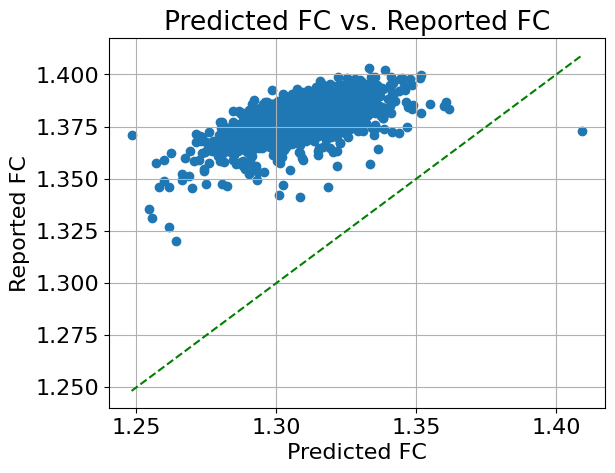

In [205]:
plt.scatter(fc_all['fc_predicted'], fc_all['total.fc'])
plt.xlabel('Predicted FC')
plt.ylabel('Reported FC')
plt.plot([min(fc_all['fc_predicted']), max(fc_all['fc_predicted'])], [min(fc_all['fc_predicted']), max(fc_all['fc_predicted'])], 'g--', label='x=y line')
plt.title('Predicted FC vs. Reported FC')
plt.grid(True)
plt.show()

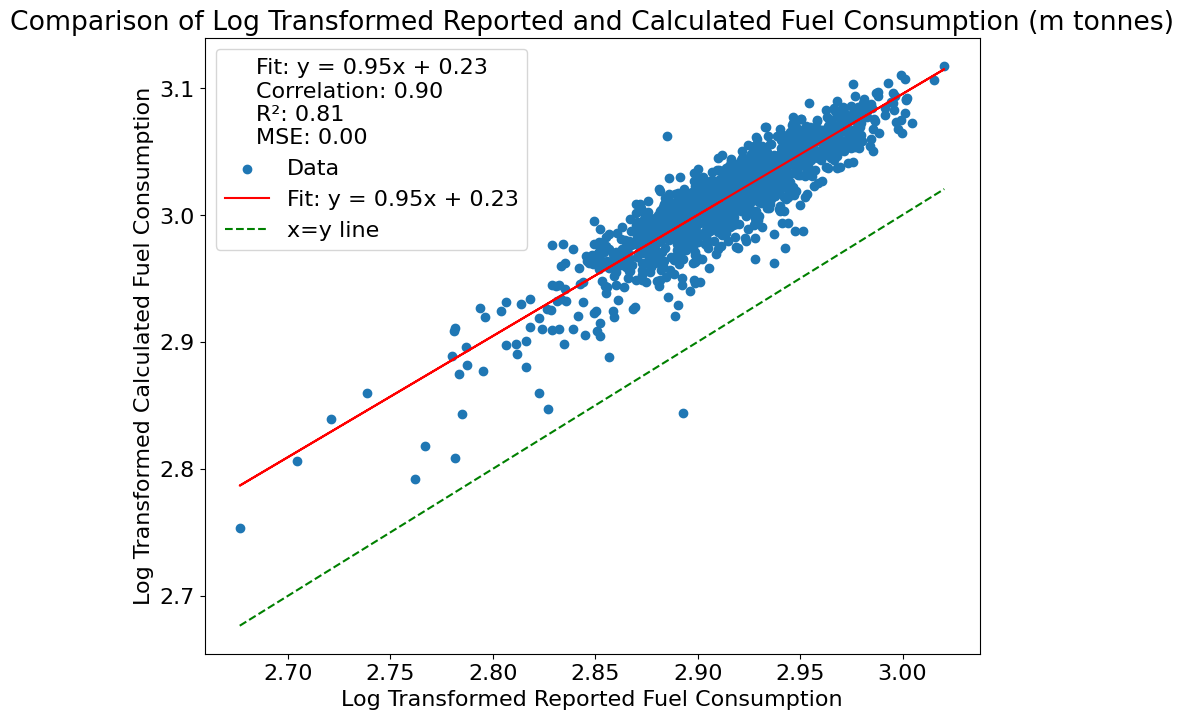

In [118]:
# Convert pandas series to numpy arrays and apply log transformation
fc_reported = fc_all['total.fc'].values
fc_predicted = fc_all['FC_sum'].values

# Fit a line to the data
slope, intercept = np.polyfit(fc_reported, fc_predicted, 1)

# Generate x values and fitted y values
x_values = fc_reported
y_values = slope * x_values + intercept

# Calculate R-squared
r_squared = r2_score(fc_predicted, y_values)

# Calculate correlation
correlation = np.corrcoef(fc_reported, fc_predicted)[0,1]

# Calculate mean squared error
mse = mean_squared_error(fc_predicted, y_values)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(fc_reported, fc_predicted, label='Data')

# Plot the line of best fit
plt.plot(x_values, y_values, color='red', label='Fit: y = {:.2f}x + {:.2f}'.format(slope, intercept))

# Plot x=y reference line
plt.plot([min(fc_reported), max(fc_reported)], [min(fc_reported), max(fc_reported)], 'g--', label='x=y line')

# Set x and y labels
plt.xlabel('Log Transformed Reported Fuel Consumption')
plt.ylabel('Log Transformed Calculated Fuel Consumption')

# Set a title for the plot
plt.title('Comparison of Log Transformed Reported and Calculated Fuel Consumption (m tonnes)')

# Add details in legend about correlation, r-squared and mean squared error
legend_title = 'Fit: y = {:.2f}x + {:.2f}\nCorrelation: {:.2f}\nR²: {:.2f}\nMSE: {:.2f}'.format(slope, intercept, correlation, r_squared, mse)
plt.legend(title=legend_title)

# Show the plot
plt.show()

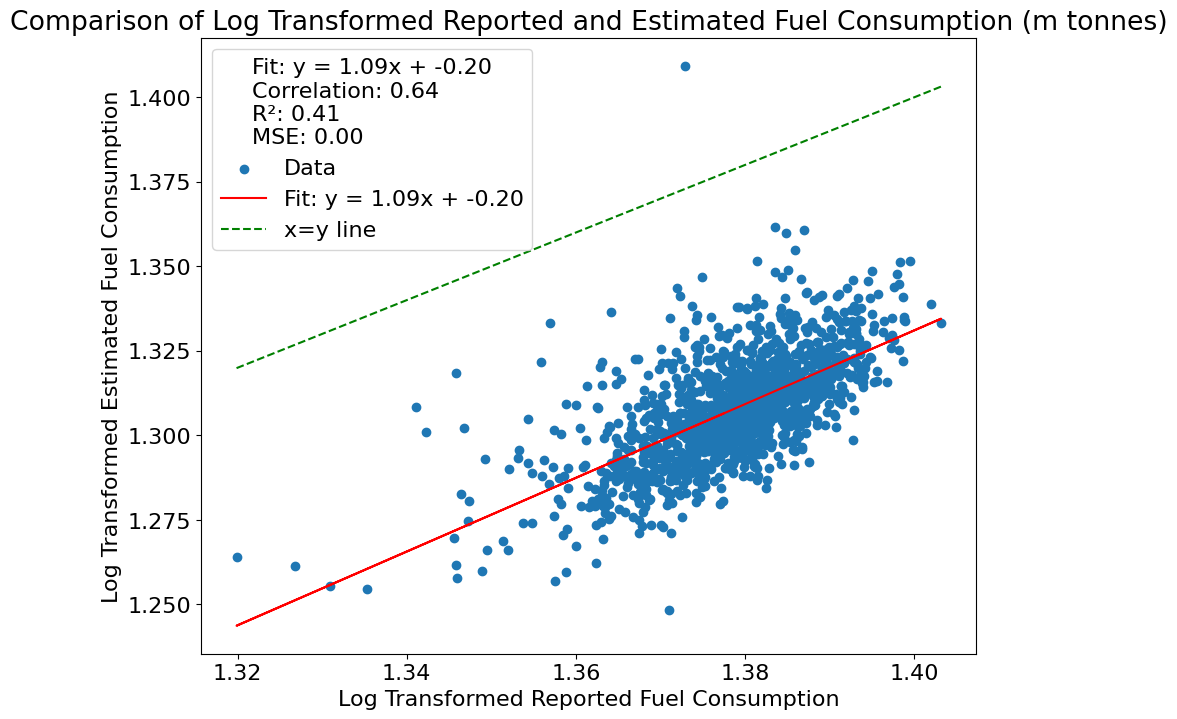

In [206]:
# Convert pandas series to numpy arrays and apply log transformation
fc_reported = fc_all['total.fc'].values
fc_predicted = fc_all['fc_predicted'].values

# Fit a line to the data
slope, intercept = np.polyfit(fc_reported, fc_predicted, 1)

# Generate x values and fitted y values
x_values = fc_reported
y_values = slope * x_values + intercept

# Calculate R-squared
r_squared = r2_score(fc_predicted, y_values)

# Calculate correlation
correlation = np.corrcoef(fc_reported, fc_predicted)[0,1]

# Calculate mean squared error
mse = mean_squared_error(fc_predicted, y_values)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(fc_reported, fc_predicted, label='Data')

# Plot the line of best fit
plt.plot(x_values, y_values, color='red', label='Fit: y = {:.2f}x + {:.2f}'.format(slope, intercept))

# Plot x=y reference line
plt.plot([min(fc_reported), max(fc_reported)], [min(fc_reported), max(fc_reported)], 'g--', label='x=y line')

# Set x and y labels
plt.xlabel('Log Transformed Reported Fuel Consumption')
plt.ylabel('Log Transformed Estimated Fuel Consumption')

# Set a title for the plot
plt.title('Comparison of Log Transformed Reported and Estimated Fuel Consumption (m tonnes)')

# Add details in legend about correlation, r-squared and mean squared error
legend_title = 'Fit: y = {:.2f}x + {:.2f}\nCorrelation: {:.2f}\nR²: {:.2f}\nMSE: {:.2f}'.format(slope, intercept, correlation, r_squared, mse)
plt.legend(title=legend_title)

# Show the plot
plt.show()